In [30]:
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
sys.path.append("../Beijing_air_quality/experiments")
from common_utils import get_measurement
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 9
})

In [55]:
#Loading AIQ data
history = 4
features_names = pickle.load(open("../Beijing_air_quality/features_names", "rb"))
signal = pickle.load(open("../Beijing_air_quality/signal", "rb"))
forecasts = pickle.load(open("../Beijing_air_quality/forecasts", "rb"))
standardizing_parameters = pickle.load(open("../Beijing_air_quality/standardizing_parameters", "rb"))

data = dict()
true_data = dict()
for m in standardizing_parameters.keys():
    _d = []
    for i in range(2):
        _d_i = get_measurement(forecasts[i], m, features_names, history, standardizing_parameters)[0]
        _d.append(np.swapaxes(_d_i, 0, 1))
    true_data[m] = get_measurement(signal, m, features_names, history, standardizing_parameters)[0]
    data[m] = np.array(_d)

num_samples = 10000
time_offset = 10
idx_0 = num_samples - time_offset
n_steps = 100
n_timesteps = 3
hours = np.linspace(0, n_steps*n_timesteps, n_steps) - n_timesteps*time_offset
measurements = ['NO2', 'O3']
units = r"[\mu g/m^3]$"
measurements_label = [r"$\rm{NO}_2~" + units, r"$\rm{O}_3~" + units]
step_forward = 1
AIQ_data = [data[m][:,step_forward - 1,...] for m in measurements]
hours = np.linspace(0, n_steps*n_timesteps, n_steps) +  (- n_timesteps + step_forward -1)*time_offset

# Loading Logistic Map Data
tikhonov_reg, noiseless = pickle.load(open("../synthetic_systems/zero_noise", "rb"))
_, noisy = pickle.load(open("../synthetic_systems/noisy", "rb"))
tikhonov_data = [noiseless, noisy]
regressors_names = ["Principal Component Regression", "Reduced Rank", "Kernel Ridge"]
noise_info = [r"$\xi = 0$", r"$\xi \sim \rm{N}(0,0.1)$"]

### Main text figure

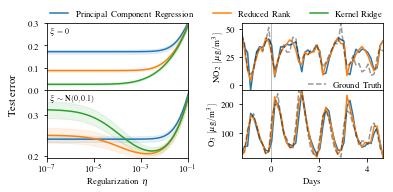

In [60]:
variables_idx_dict = {
    'tikhonov_regs': None
}
fig_width = 5.5 #Inches
fig_height =fig_width/2 #Inches
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(fig_width, fig_height), sharex='col')
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_reg_path(ax, data, regularizations, color, label):
    mean = data[0]
    std = data[1]
    ax.fill_between(regularizations, mean - std, mean + std, color=color, alpha = 0.1)
    ax.plot(regularizations, mean, color=color, label=label)

def plot_forecast(ax, data, time, color, style='-', alpha = 1, label = None):
    ax.plot(time, data, style, alpha = alpha, color=color, label = label)

for col_idx in range(2):
    for row_idx in range(2):
        ax = axes[row_idx, col_idx]
        if col_idx == 0:
            for regressor_idx in range(3):
                color = cycle[regressor_idx]
                plot_reg_path(ax, tikhonov_data[row_idx][:,regressor_idx,0,0,:], tikhonov_reg, color, label = regressors_names[regressor_idx])
            ax.margins(0)
            ax.set_xscale('log')
            
            if row_idx == 1:
                ax.set_xlabel('Regularization $\gamma$')                
            else:
                ax.legend(bbox_to_anchor=(0,1.02,2.4,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, frameon=False)
                ax.set_ylim([0, 0.3])
            ylims = ax.get_ylim()
            y_pos = ylims[0] + (ylims[1] - ylims[0])*0.85
            ax.text(tikhonov_reg[1], y_pos, noise_info[row_idx], fontsize=8)
        if col_idx == 1:
            num = 48
            time = hours[:num]/24
            ax.axvline(x=0, color='k', linestyle='-', lw=0.5, alpha = 0.5)
            for regressor_idx in range(2):
                color = cycle[regressor_idx]
                plot_forecast(ax, AIQ_data[row_idx][regressor_idx].mean(axis=1)[:num],time, color)
                
            ground_truth = true_data[measurements[row_idx]][idx_0 + step_forward:(idx_0 + n_steps + step_forward)].mean(axis=1)[:num]
            plot_forecast(ax, ground_truth,time, 'k', alpha = 0.4, style = '--', label='Ground Truth')
            ax.margins(0)
            ax.set_ylabel(measurements_label[row_idx])
            if row_idx == 1:
                ax.set_xlabel('Days')
            else:
                ax.legend(bbox_to_anchor=(1.05,-0.1,0,0), frameon=False, loc='lower right')
fig.supylabel('Test error')
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.savefig("main_text_experiment.pdf")

### Deep Learning + Dynamical systems

In [9]:
data = np.load("../MNIST_prediction/_img_data.npy")
num_classes = data.shape[1] - 1
labels = ['Linear Kernel', 'Gaussian Kernel', 'CNN Kernel']

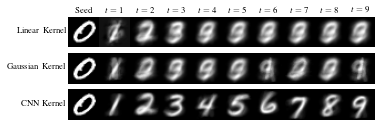

In [45]:
fig_width = 5.5 #Inches
fig_height = 2 #Inches
fig, axes = plt.subplots(nrows = data.shape[0], ncols=num_classes, figsize=(fig_width, fig_height))
plt.subplots_adjust(wspace=0, hspace=0)
style = "Simple, tail_width=0.5, head_width=4, head_length=5"
kw = dict(arrowstyle=style, color="k")
for row in range(data.shape[0]):
    for col in range(num_classes):
        ax = axes[row, col]
        ax.axis('off')
        Y_val = data[row, col]
        ax.imshow(Y_val, cmap="gray")
        if col == 0:
            ax.text(-2, 14, labels[row], ha='right')
        if row == 0:
            if col == 0:
                ax.text(14, -4, "Seed", ha='center')
            elif 0 < col < num_classes:
                ax.text(14, -4, r"$t = {}$".format(col), ha='center')
                #arrow = patches.FancyArrowPatch((14, -1), (42, -1), connectionstyle="arc3,rad=-.5", clip_on=False, **kw)
                #ax.add_patch(arrow)
            
plt.savefig("CNN_kernel.pdf", bbox_inches='tight')